<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.clustering-and-anomaly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


--2020-04-01 10:32:53--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2787 (2.7K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   2.72K  --.-KB/s    in 0s      

2020-04-01 10:32:53 (81.1 MB/s) - ‘andrea_models.py’ saved [2787/2787]

--2020-04-01 10:32:55--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request s

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's fix the random seed. In Python, setting a seed is [a mess](https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752) ([2](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/), [3](https://github.com/scikit-learn/scikit-learn/issues/10237) )

In [0]:
np.random.seed(9)
random.seed(9)

**Goal**: 
Find fraudolent credit card transactions

**Dataset**:
* From [DataHub](https://datahub.io/machine-learning/creditcard)
* Anonimized transactions
* Features have no precise meaning: obtained via Principal Component Analysis (PCA)
* Ground truth: transactions labeled as normal/anomaly

In [3]:
! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

--2020-04-01 10:33:04--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.18.49.253, 104.18.48.253, 2606:4700:3033::6812:31fd, ...
Connecting to datahub.io (datahub.io)|104.18.49.253|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2020-04-01 10:33:05--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.18.48.253, 104.18.49.253, 2606:4700:3031::6812:30fd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.18.48.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv’

creditcard.csv      100%[===================>] 144.11M   153MB/s    in 0

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df['Class'].value_counts()

'0'    284315
'1'       492
Name: Class, dtype: int64

The anomalies are the minority.

In [7]:
num_of_normal = sum( df['Class']=="'0'" )
num_of_anomalies = sum( df['Class']=="'1'" )
num_of_anomalies/num_of_normal

0.0017304750013189597

Remove the time, since it has no meaning for discovering anomalies for us.

In [0]:
df = df.drop('Time', axis=1)

We put the label aside

In [0]:
X = df.drop('Class', axis=1)
y = df['Class']

All the methods we will use, except iForests, performs best if the dataset is scaled

In [0]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means clustering

Before detecting anomalies, look for a "good" clustering.

Start with K=3 clusters.

In [0]:
K =3
model = KMeans(n_clusters=K)
clusters = model.fit_predict(X_scaled)

The array "`clusters`" contains the cluster id of each sample

In [12]:
clusters[0:5]

array([2, 2, 1, 1, 2], dtype=int32)

Check how many elements per cluster

(array([ 20308.,      0.,      0.,      0.,      0.,  40453.,      0.,
             0.,      0., 224046.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

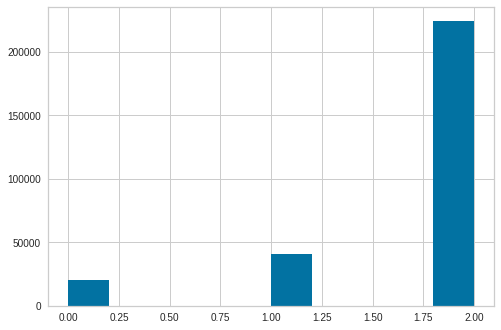

In [13]:
plt.hist(clusters)

Inertia (sum of squared distances between a sample and its centroid)

In [14]:
model.inertia_

7689781.829537551

### Number of random initializations

In sklearn, Kmeans algorithm is repeated `n_init` times (by default 10), so to produce 10 models. The model with the smallest inertia is selected.

How to know if `n_init` is enough or we should increase it? Intuitively, the more the dimensions (features), the more random initializations we would need.

Suggestion: Repeat KMeans many times, increasing `n_init` until you see that the inertia stops improving.

To go fast, do this on a smaller subset.

In [15]:
help(subsample)

Help on function subsample in module andrea_models:

subsample(X, y, n, random_state)
    Take a subsample of X and y composed of n rows.
    
    Parameters
    -------------------
    X:              Array
    y:              Array. It must have the same rows as X
    n:              Number of rows to take
    random_state:   the seed
    
    
    Returns
    -------------------
    X_sub:  A sample of n rows from X, selected randomly
    y_sub:  A sample of n rows from y. The same row ids of X_sub are 
                    selected



In [15]:
n_samples = 10000
X_sub = subsample(X_scaled, n_samples)

TypeError: ignored

In [20]:
inertia_values = []

repeats = range(10, 100, 10)

for r in repeats:
  model = KMeans(K, n_init=r)
  model.fit_predict(X_sub)
  inertia_values.append(model.inertia_)

plt.plot(repeats, inertia_values)

NameError: ignored

### Silhouette

To evaluate the goodness of clustering, we compute the silhouette score 

=> Infeasible on the entire dataset!

Recall that you need to compute the distances between all samples, i.e.

In [49]:
print("Distances to be computed: ", "{:e}".format( X_scaled.shape[0]**2) )

Distances to be computed:  8.111503e+10


We will just check the silhouette on a random subset of samples.

In [0]:
X_sub, clusters_sub = subsample(X_scaled, clusters, n=10000 , random_state=3)

In [51]:
# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X_sub, clusters_sub)
silhouette_avg



0.17225785705438693

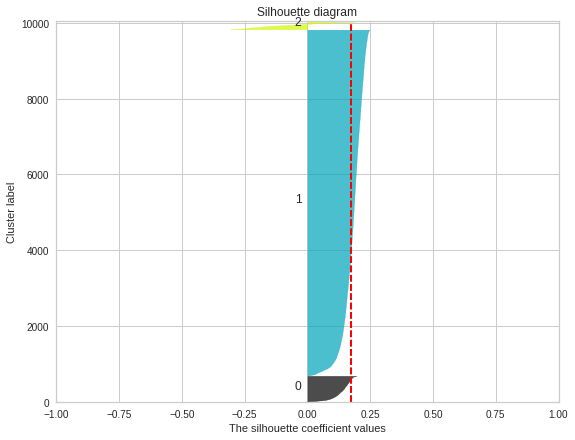

In [52]:
sample_silhouette_values = silhouette_diagram(X_sub, clusters_sub, K)


Clustering is bad. The silhouette score is << 1 and the silhouette values are quite low. Let us plot the silhouette score varying K.

However, we are evaluating silhouette only on a subset of samples. If we change subset, we may observe different silhouette for the same clusters:

Silhouette score= 0.17740111304607611


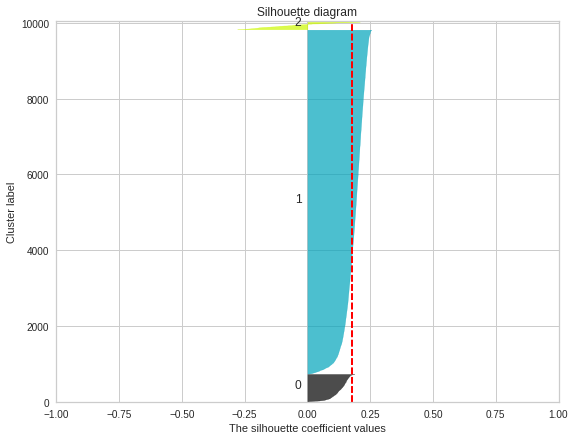

In [54]:
X_sub, clusters_sub = subsample(X_scaled, clusters, n=10000 , random_state=5)
silhouette_avg = silhouette_score(X_sub, clusters_sub)
print("Silhouette score=",silhouette_avg)
sample_silhouette_values = silhouette_diagram(X_sub, clusters_sub, K)

For K= 2  the silhouette score is  0.13836270967802836
For K= 3  the silhouette score is  0.17225785705438693
For K= 4  the silhouette score is  0.0724681714232781


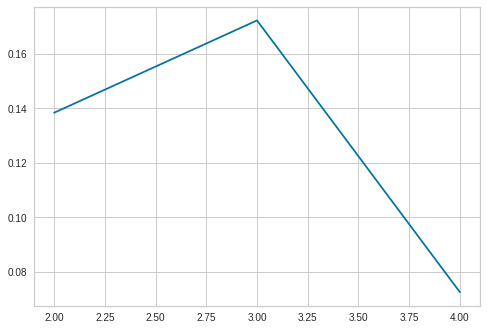

In [55]:
max_clusters = 5

scores = []

for K in range (2,max_clusters):
  # To avoid using always the same seed, let's change the random state every time
  model = KMeans(n_clusters = K, random_state=3)
  clusters = model.fit_predict(X_scaled)

  # Take a subsample of X_scaled, in order to compute the silhouette score
  # (for scalability)
  X_sub, clusters_sub = subsample(X_scaled, clusters, n=10000 , random_state=3)

  silhouette_avg = silhouette_score(X_sub, clusters_sub)
  scores.append(silhouette_avg)
  print ("For K=",K, " the silhouette score is ", silhouette_avg)

plt.plot(range (2,max_clusters), scores)

For K= 2  the silhouette score is  0.128748541382009
For K= 3  the silhouette score is  0.17740111304607611
For K= 4  the silhouette score is  0.07354172436598118


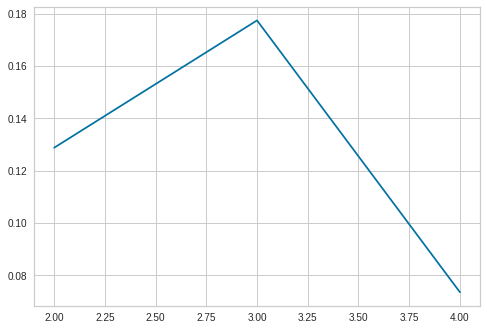

In [56]:
scores = []

for K in range (2,max_clusters):
  # To avoid using always the same seed, let's change the random state every time
  model = KMeans(n_clusters = K, random_state=3)
  clusters = model.fit_predict(X_scaled)

  # Take a subsample of X_scaled, in order to compute the silhouette score
  # (for scalability)
  X_sub, clusters_sub = subsample(X_scaled, clusters, n=10000 , random_state=5)

  silhouette_avg = silhouette_score(X_sub, clusters_sub)
  scores.append(silhouette_avg)
  print ("For K=",K, " the silhouette score is ", silhouette_avg)

plt.plot(range (2,max_clusters), scores)

# Todo

Check:
* https://medium.com/datadriveninvestor/credit-card-fraud-detection-using-local-outlier-factor-and-isolation-forest-in-python-56edd0a44af5
* https://www.inovex.de/blog/online-offline-machine-learning-network-anomaly-detection/
* https://medium.com/learningdatascience/anomaly-detection-techniques-in-python-50f650c75aaf